In [1]:
import sys

In [106]:
BASE_DIR = "../.."
DATA_DIR = f"{BASE_DIR}/data"
NBDATA_DIR = f"{BASE_DIR}/nbdata"
FIG_DIR = f"{BASE_DIR}/figs"

In [11]:
sys.path.append(BASE_DIR)

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
import anndata as ad
import scanpy as sc

## Read Data

### Transcriptomic

In [65]:
rna_adata = ad.read_excel(f"{DATA_DIR}/iMN_DESeq_DataLevel3_20170426_COMPLETE.xlsx",sheet="iMNs_DESeq_JUL2015_all_merged").T

In [66]:
rna_meta = pd.read_csv(f"{DATA_DIR}/Differentiated_Cell_Metadata.txt",sep="\t")
rna_meta["Condition"] = rna_meta.DC_Name.transform(lambda x: x.split("_")[0][-3:])
rna_adata.obs = rna_meta

In [107]:
rna_adata.obs[['dc_center_batch_id','Condition']].to_csv(f'{NBDATA_DIR}/iMN_id_condition_map.tsv',sep='\t',header=True,index=False)

## Gene Name Mapping

In [31]:
import biomart                                                                                                                                                                                              

def get_ensembl_mappings():    
    # from https://gist.github.com/ben-heil/cffbebf8865795fe2efbbfec041da969
    # Set up connection to server                                                                                                                                                                           
    server = biomart.BiomartServer('http://useast.ensembl.org/biomart')                                                                                                                                     
    mart = server.datasets['hsapiens_gene_ensembl']                                                                                                                                                        

    # List the types of data we want                                                                                                                                                                        
    attributes = ['ensembl_transcript_id', 'hgnc_symbol',                                                                                                                                                    
                  'ensembl_gene_id', 'ensembl_peptide_id']                                                                                                                                                  

    # Get the mapping between the attributes                                                                                                                                                                
    response = mart.search({'attributes': attributes})                                                                                                                                                      
    data = response.raw.data.decode('ascii')                                                                                                                                                                

    ensembl_to_genesymbol = {}                                                                                                                                                                              
    # Store the data in a dict                                                                                                                                                                              
    for line in data.splitlines():                                                                                                                                                                          
        line = line.split('\t')                                                                                                                                                                             
        # The entries are in the same order as in the `attributes` variable                                                                                                                                 
        transcript_id = line[0]                                                                                                                                                                             
        gene_symbol = line[1]                                                                                                                                                                               
        ensembl_gene = line[2]                                                                                                                                                                              
        ensembl_peptide = line[3]                                                                                                                                                                           

        # Some of these keys may be an empty string. If you want, you can
        # avoid having a '' key in your dict by ensuring the
        # transcript/gene/peptide ids have a nonzero length before
        # adding them to the dict
        ensembl_to_genesymbol[transcript_id] = gene_symbol
        ensembl_to_genesymbol[ensembl_gene] = gene_symbol
        ensembl_to_genesymbol[ensembl_peptide] = gene_symbol

    return ensembl_to_genesymbol

ens2gene = get_ensembl_mappings()

In [32]:
from gprofiler import GProfiler
from tqdm.notebook import tqdm

def get_ens2hgnc_mappings(query_list):

    gp = GProfiler(return_dataframe=True)
    gp_database = gp.convert(organism='hsapiens',query=query_list, target_namespace='HGNC').set_index('incoming')
    
    ens2hgnc = {}
    for ens in tqdm(query_list):
        mapper = gp_database.loc[ens,'converted']
        if not isinstance(mapper,str):
            mapper = mapper[0]
        if mapper == 'None':
            mapper = ens
        ens2hgnc[ens] = mapper
    
        
    return ens2hgnc

ens2gene = get_ens2hgnc_mappings(list(rna_adata.var.index))

  0%|          | 0/63769 [00:00<?, ?it/s]

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


In [72]:
rna_adata.var['HGNC'] = rna_adata.var.index.map(ens2gene)

## Split by Condition

In [73]:
rna_adata_ctr = rna_adata[rna_adata.obs.Condition == 'CTR']
rna_adata_als = rna_adata[rna_adata.obs.Condition == 'ALS']
rna_adata_sma = rna_adata[rna_adata.obs.Condition == 'SMA']

/afs/csail.mit.edu/u/s/samsl/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


## RNA Preprocessing and QC

In [74]:
def preprocess_and_qc(adata):
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=3)
    
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    
    adata.var['mt'] = adata.var.HGNC.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, inplace=True)
    
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
    
    return adata

In [97]:
rna_adata_ctr = preprocess_and_qc(rna_adata_ctr)
rna_adata_als = preprocess_and_qc(rna_adata_als)

/afs/csail.mit.edu/u/s/samsl/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/afs/csail.mit.edu/u/s/samsl/Work/anaconda3/envs/dsplat/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/afs/csail.mit.edu/u/s/samsl/.local/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:297: DeprecationWarning: Use is_view instead of isview, isview will be removed in the future.
  if isinstance(data, AnnData) and data.isview:


/afs/csail.mit.edu/u/s/samsl/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/afs/csail.mit.edu/u/s/samsl/Work/anaconda3/envs/dsplat/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/afs/csail.mit.edu/u/s/samsl/.local/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:297: DeprecationWarning: Use is_view instead of isview, isview will be removed in the future.
  if isinstance(data, AnnData) and data.isview:


### Highly Variable Genes

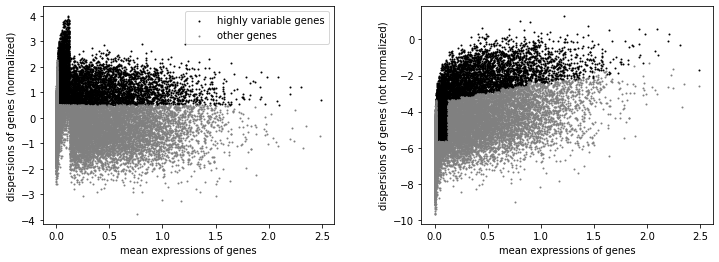

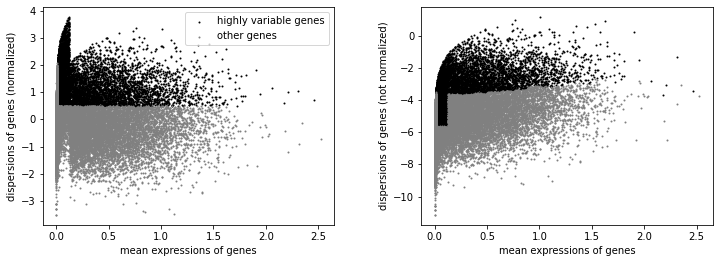

In [98]:
sc.pl.highly_variable_genes(rna_adata_als)
sc.pl.highly_variable_genes(rna_adata_ctr)

In [99]:
rna_adata_ctr.var[rna_adata_ctr.var.highly_variable].sort_values(by='total_counts',ascending=False).head()

,HGNC,n_cells,mt,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,highly_variable,means,dispersions,dispersions_norm
ENSG00000258486,ENSG00000258486,6,False,6,2.460418,1.241389,0.0,14.762506,2.757634,True,2.461515,-3.412549,0.707107
ENSG00000226958,ENSG00000226958,6,False,6,2.296935,1.192993,0.0,13.781609,2.693384,True,2.307042,-1.308264,1.064214
ENSG00000259001,ENSG00000259001,6,False,6,2.207088,1.165363,0.0,13.242527,2.656232,True,2.209067,-3.062778,1.013667
ERCC-00130,ERCC-00130,6,False,6,2.172574,1.154543,0.0,13.035443,2.641586,True,2.173660,-3.684714,0.609983
ENSG00000167552,TUBA1A,6,False,6,2.058805,1.118024,0.0,12.352832,2.591728,True,2.061725,-2.801998,1.154325


In [100]:
rna_adata_als.var[rna_adata_als.var.highly_variable].sort_values(by='total_counts',ascending=False).head()

,HGNC,n_cells,mt,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,highly_variable,means,dispersions,dispersions_norm
ENSG00000258486,ENSG00000258486,8,False,8,2.484627,1.248361,0.0,19.877014,3.038649,True,2.491147,-1.684475,0.707107
ENSG00000115414,FN1,8,False,8,2.276970,1.186919,0.0,18.215761,2.955731,True,2.306913,-0.321165,1.201244
ENSG00000108821,COL1A1,8,False,8,2.158278,1.150027,0.0,17.266220,2.905053,True,2.199738,-0.083844,0.929051
ENSG00000168542,COL3A1,8,False,8,2.138102,1.143618,0.0,17.104818,2.896178,True,2.204723,0.316570,1.209062
ENSG00000113140,SPARC,8,False,8,2.079964,1.124918,0.0,16.639709,2.870152,True,2.100101,-0.844127,0.508704


### Fold Change in Case/Control Mean Counts

In [101]:
fold_change = rna_adata_als.var[['HGNC','mean_counts']].set_index('HGNC') / rna_adata_ctr.var[['HGNC','mean_counts']].set_index('HGNC')

In [102]:
fold_change.sort_values(by='mean_counts',ascending=False)

,mean_counts
HGNC,
ITGBL1,599.974915
IGFL3,333.582947
MYCT1,97.507507
LINC01164,87.762924
IGFL2,68.594177
...,...
ZNF99,NaN
ZNRF2P3,NaN
ZP4,NaN


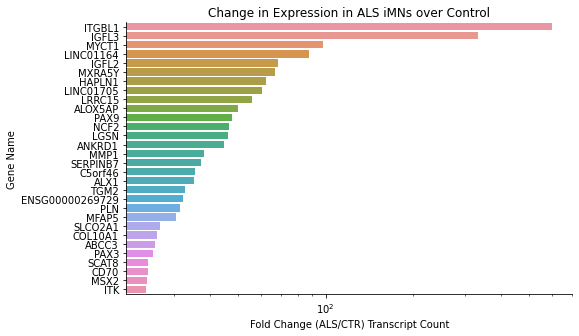

In [103]:
plt.figure(figsize=(8, 5))
sns.barplot(data=fold_change.reset_index().sort_values(by='mean_counts',ascending=False).head(30),y='HGNC',x='mean_counts')
sns.despine()
plt.ylabel('Gene Name')
plt.xlabel('Fold Change (ALS/CTR) Transcript Count')
# plt.xscale('log',base=2)
plt.xscale('log')
plt.title('Change in Expression in ALS iMNs over Control')
plt.savefig(f"{FIG_DIR}/iMN_als_ctr_fold_change_rna.png",bbox_inches='tight')

### Highly Expressed (- mitochondrial)

/afs/csail.mit.edu/u/s/samsl/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/afs/csail.mit.edu/u/s/samsl/Work/anaconda3/envs/dsplat/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


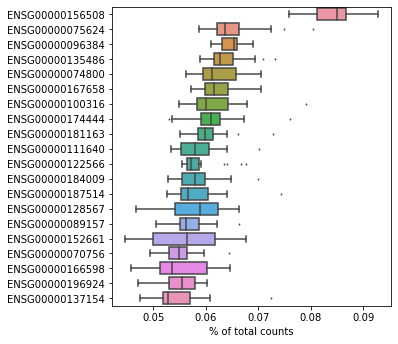

In [44]:
sc.pl.highest_expr_genes(rna_adata[:,~rna_adata.var.mt], n_top=20, )

In [45]:
rna_adata[:,~rna_adata.var.mt].var.sort_values(by='total_counts',ascending=False)

/afs/csail.mit.edu/u/s/samsl/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/afs/csail.mit.edu/u/s/samsl/Work/anaconda3/envs/dsplat/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


,HGNC,n_cells,mt,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,highly_variable,means,dispersions,dispersions_norm
ENSG00000156508,EEF1A1,29,False,29,4.422039,1.690472,0.000000,128.239120,4.861664,False,4.440307,1.081052,-0.707107
ENSG00000075624,ACTB,29,False,29,3.423992,1.487042,0.000000,99.295761,4.608123,False,3.446537,0.474388,0.169538
ENSG00000096384,HSP90AB1,29,False,29,3.400498,1.481718,0.000000,98.614456,4.601307,False,3.406837,-0.909180,-1.198873
ENSG00000135486,HNRNPA1,29,False,29,3.342783,1.468516,0.000000,96.940720,4.584363,False,3.351440,-0.624069,-0.916885
ENSG00000074800,ENO1,29,False,29,3.269775,1.451561,0.000000,94.823463,4.562508,False,3.296112,0.504974,0.199789
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000231983,LINC00415,3,False,3,0.000036,0.000036,89.655172,0.001034,0.001033,False,0.000036,-8.045547,-0.991768
ENSG00000211780,TRAV6,3,False,3,0.000035,0.000035,89.655172,0.001027,0.001026,False,0.000035,-8.052823,-0.997443
ENSG00000260487,,3,False,3,0.000035,0.000035,89.655172,0.001027,0.001026,False,0.000035,-8.052955,-0.997546
ENSG00000254472,OR4A49P,3,False,3,0.000035,0.000035,89.655172,0.001027,0.001026,False,0.000035,-8.052955,-0.997546


## Write H5

In [79]:
control_save_path = f"{BASE_DIR}/nbdata/iMN_rna_ctr_preprocessed.h5ad"
als_save_path = f"{BASE_DIR}/nbdata/iMN_rna_als_preprocessed.h5ad"

In [91]:
rna_adata_als.obs = rna_adata_als.obs[['DC_Name', 'Condition']]
rna_adata_als.var = rna_adata_als.var[['HGNC']]

In [92]:
rna_adata_ctr.obs = rna_adata_ctr.obs[['DC_Name', 'Condition']]
rna_adata_ctr.var = rna_adata_ctr.var[['HGNC']]

In [93]:
rna_adata_als.write(als_save_path)

In [94]:
rna_adata_ctr.write(control_save_path)

# Write Transcription Factors as txt

In [43]:
tf_list = pd.read_csv(f'{DATA_DIR}/HumanTFs.csv',index_col=1)

In [44]:
common_tfs = set(rna_adata.var.index).intersection(set(tf_list.index))

In [45]:
with open('../../nbdata/iMN_human_tflist.txt','w+') as f:
    for tf in list(common_tfs):
        f.write(f"{tf}\n")